# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
%matplotlib inline

## Read in Images

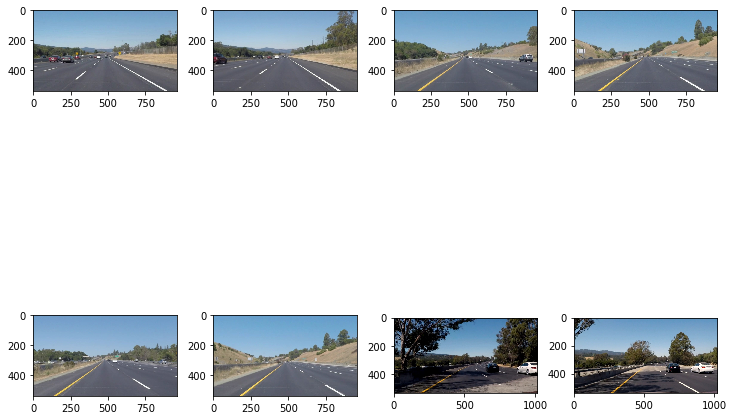

In [3]:
def show_images(images, cmap=None):
    cols = 4
    rows = (len(images))//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

show_images(test_images)

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

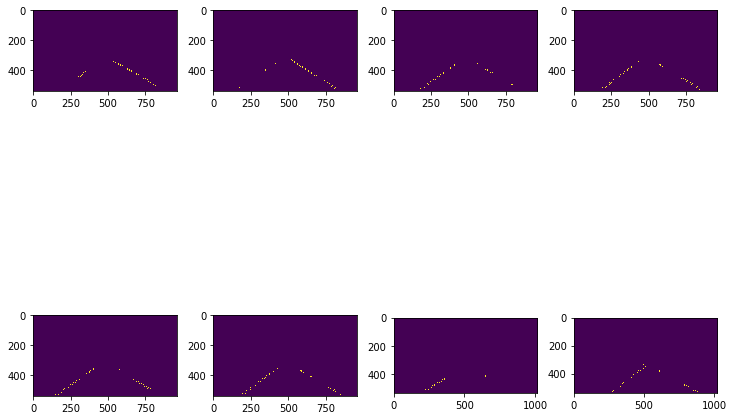

In [9]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=15):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def low_middle_vertices(image):

    ysize, xsize = image.shape[:2]
    bottom_left  = [xsize*0.1, ysize*0.99]
    top_left     = [xsize*0.4, ysize*0.6]
    bottom_right = [xsize*0.9, ysize*0.99]
    top_right    = [xsize*0.6, ysize*0.6]

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(img)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(img, 1.0, line_image, 0.95, 0.0)

    
def hough_lines(img, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=250):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=minLineLength, maxLineGap=maxLineGap)

    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def select_rgb_white_yellow(image): 
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white
    lower = np.uint8([0, 200, 0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow
    lower = np.uint8([0, 0,   100])
    upper = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)

    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked


def get_lane_from_segements(image, lines):
    global last_r_slope, last_l_slope, last_r_intercept, last_l_intercept
    
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)

    ysize = image.shape[0]
    xsize = image.shape[1]

    l_slope = 0
    l_intercept = 0
    l_length = 1

    r_slope = 0
    r_intercept = 0
    r_length = 1

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            
            if (slope == 0): # ignore horizontal
                continue
            else:
                bottom_intercept = (ysize - intercept)/slope
                
            if x2==x1:  # ignore vertical
                continue

            if bottom_intercept < 0.45 * xsize: # 
                l_slope = l_slope + slope * length
                l_length = l_length + length
                l_intercept = l_intercept + intercept * length

            elif bottom_intercept > 0.55 * xsize:
                r_slope = r_slope + slope * length
                r_length = r_length + length
                r_intercept = r_intercept + intercept * length

    if(r_slope == 0 or l_slope == 0):
        print("slope is zero! ", lines, l_slope, r_slope, l_length, r_length)
        plt.imshow(image)
        plt.show()
    
    last_l_slope, last_l_intercept, last_r_slope, last_r_intercept = l_slope, l_intercept, r_slope, r_intercept
    y_ratio = 0.65
    r_slope = r_slope / r_length
    r_intercept = r_intercept / r_length
        
    l_slope = l_slope / l_length
    l_intercept = l_intercept / l_length

    l_x1 = int((ysize - l_intercept) / l_slope)
    l_y1 = ysize

    l_x2 = int(( int(y_ratio * ysize) - l_intercept) / l_slope)
    l_y2 = int(y_ratio * ysize)

    r_x1 = int((ysize - r_intercept) / r_slope)
    r_y1 = ysize

    r_x2 = int(( int(y_ratio * ysize) - r_intercept) / r_slope)
    r_y2 = int(y_ratio * ysize)

    return ((l_x1, l_y1), (l_x2,l_y2)), ((r_x1, r_y1), (r_x2,r_y2))

def draw_my_lines(img, lines, color=[255, 0, 0], thickness=16):
    line_image = np.zeros_like(img)
    #print("image:")
    for line in lines:
        #print("line:", (line[0][0],line[0][1]),(line[1][0],line[1][1]))
        cv2.line(line_image,(line[0][0],line[0][1]),(line[1][0],line[1][1]),(255,0,0),thickness)

    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(img, 1.0, line_image, 0.95, 0.0)


def step_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    lane_image = np.copy(image)

    color_image = select_rgb_white_yellow(image)
    gray_image = grayscale(color_image)
    blur_image = gaussian_blur(gray_image)
    cannyed_image = canny(blur_image)
    masked_image = region_of_interest(cannyed_image, low_middle_vertices(image))
    #lines = hough_lines(masked_image)
    #lanes = get_lane_from_segements(image, lines)
    #result = draw_my_lines(image, lanes)

    return masked_image

test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

rets = list(map(step_image, test_images))

show_images(rets)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


**Before testing on videos, test on images using process_image**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

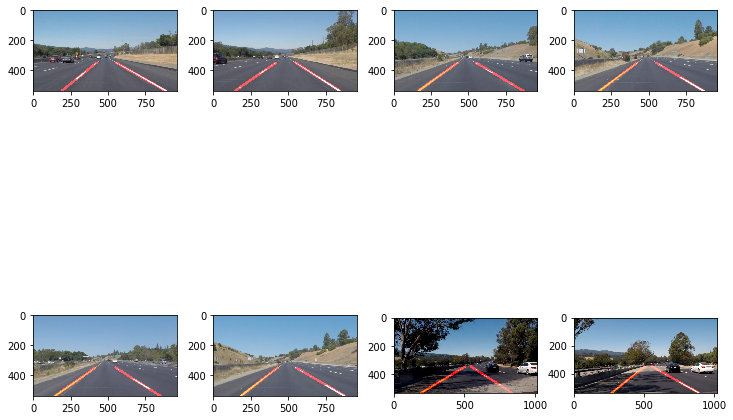

In [19]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    lane_image = np.copy(image)

    color_image = select_rgb_white_yellow(image)
    gray_image = grayscale(color_image)
    blur_image = gaussian_blur(gray_image)
    cannyed_image = canny(blur_image)
    masked_image = region_of_interest(cannyed_image, low_middle_vertices(image))
    lines = hough_lines(masked_image)
    lanes = get_lane_from_segements(image, lines)
    result = draw_my_lines(image, lanes)

    return result

test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

rets = list(map(process_image, test_images))

show_images(rets)

Let's try the one with the solid white lane on the right first ...

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_videos/solidWhiteRight.mp4"))

In [21]:
white_output = 'test_videos/solidWhiteRight_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos/solidWhiteRight_output.mp4
[MoviePy] Writing video test_videos/solidWhiteRight_output.mp4


100%|█████████▉| 221/222 [00:05<00:00, 39.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/solidWhiteRight_output.mp4 

CPU times: user 6.93 s, sys: 140 ms, total: 7.07 s
Wall time: 6.13 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [23]:
yellow_output = 'test_videos/solidYellowLeft_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos/solidYellowLeft_output.mp4
[MoviePy] Writing video test_videos/solidYellowLeft_output.mp4


100%|█████████▉| 681/682 [00:16<00:00, 40.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/solidYellowLeft_output.mp4 

CPU times: user 21 s, sys: 371 ms, total: 21.4 s
Wall time: 17.3 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos/challenge.mp4'))

In [26]:
challenge_output = 'test_videos/challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos/challenge_output.mp4
[MoviePy] Writing video test_videos/challenge_output.mp4


100%|██████████| 251/251 [00:11<00:00, 22.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/challenge_output.mp4 

CPU times: user 11.3 s, sys: 308 ms, total: 11.6 s
Wall time: 12.3 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))